In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
# dt = 0.004
# num_steps = 501
dt = 0.002
num_steps = 1001
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([1001, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

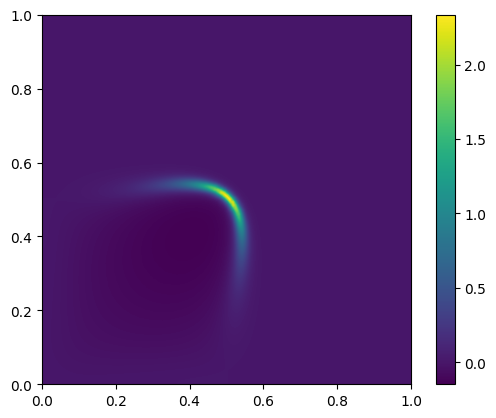

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = torch.hstack((datas[:-1], u_dot))
datas.shape

torch.Size([1000, 29282])

In [8]:
m = 50
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

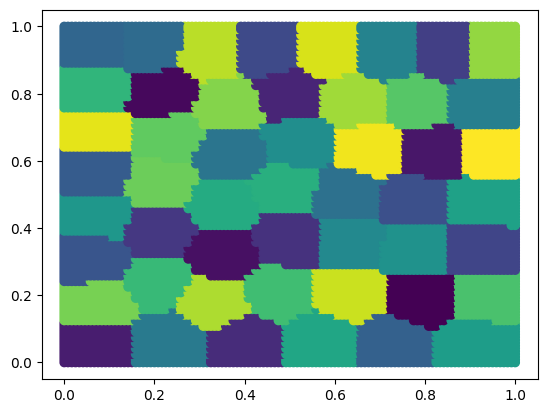

In [9]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

In [10]:
group_indices = []
for i in range(m):
    group_indices.append(torch.tensor(np.where(clustering.labels_ == i)[0], device=device))

In [11]:
N = datas.shape[1] // 2
n = 20
mu = int(np.ceil(N/200))
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [12]:
batch_size = 20
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [13]:
ed = lib.nrbs_test.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance,clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor),group_indices=group_indices, device=device)

In [14]:
ed.nrbs = torch.load('models/nrbs_n_m_test.pth')

In [22]:
ed.train(train_data_loader=train_data, epochs=1000)

100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


Itr 0, loss = 9.15176259928669


 10%|█         | 5/50 [00:04<00:37,  1.19it/s]


KeyboardInterrupt: 

In [23]:
ed.nrbs = torch.load('models/nrbs_n_m_test.pth')

In [24]:
approximates = ed(datas[999:1001, :N].to(device))
approximates.shape

torch.Size([1, 14641])

In [25]:
approximates[0]

tensor([-0.0004, -0.0007,  0.0014,  ..., -0.0018, -0.0018, -0.0014],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [26]:
datas[999:1001, N:]

tensor([[2.5000e-03, 2.4000e-03, 2.2500e-03,  ..., 4.8000e-30, 4.8000e-30,
         6.9900e-30]])

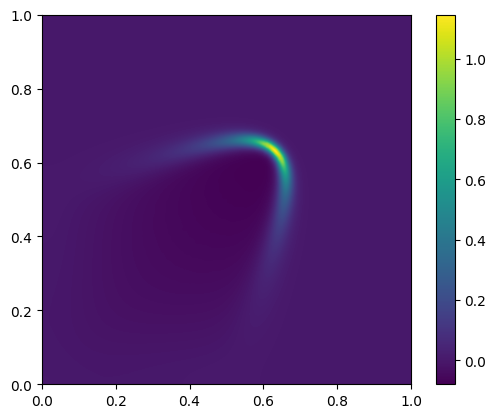

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, N:].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

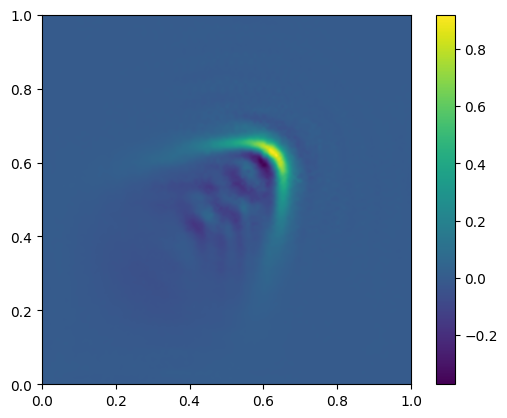

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [29]:
encoded = ed.nrbs.encode(datas[999, :N].to(device).to(device))

In [30]:
encoded.shape

torch.Size([20])

In [43]:
bandwidths = torch.sigmoid(ed.nrbs.bandwidth_layers(encoded))
bandwidths = (1 / 60 - 4 / 60 / ed.nrbs.mu) * bandwidths + 4 / 60 / ed.nrbs.mu
bandwidths = bandwidths.reshape(-1, ed.nrbs.n, ed.nrbs.m)
# b x n x N
bandwidths = bandwidths[:, :, ed.nrbs.clustering_labels]

# n x N x mu
basises = ed.nrbs.decoder.weight[:, ed.nrbs.neighbour_id]

smoothed_basis = torch.empty((1, ed.nrbs.n, ed.nrbs.N), device=ed.nrbs.device)

for i in range(len(ed.nrbs.group_indices)):
    # b x n x N/m x mu
    bubbles = ed.nrbs.bubble(
                ed.nrbs.neighbour_distance[ed.nrbs.group_indices[i], :],
                bandwidths[:, :, ed.nrbs.group_indices[i]],
                ed.nrbs.mu,
    )
    # b x n x N/m
    smoothed_basis[:, :, ed.nrbs.group_indices[i]] = torch.sum(
                (
                    (basises[:, ed.nrbs.group_indices[i], :])
                    .unsqueeze(0)
                    .expand(1, -1, -1, -1)
                )
                * bubbles,
                dim=-1,
    )

bandwidths = bandwidths.squeeze(0).detach().cpu()
convolved_bases = smoothed_basis.squeeze(0).detach().cpu()

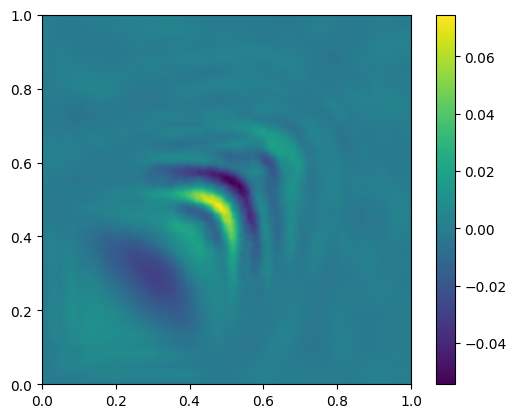

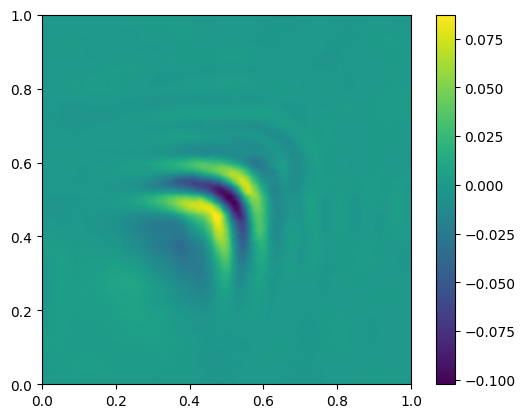

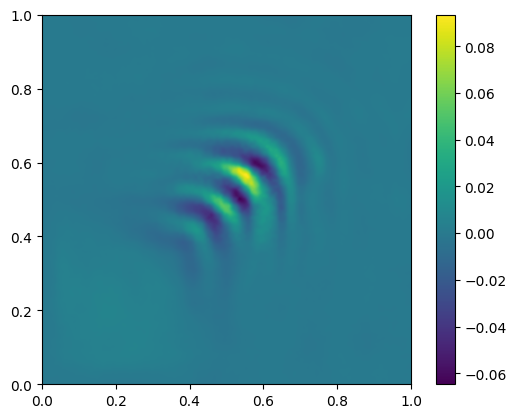

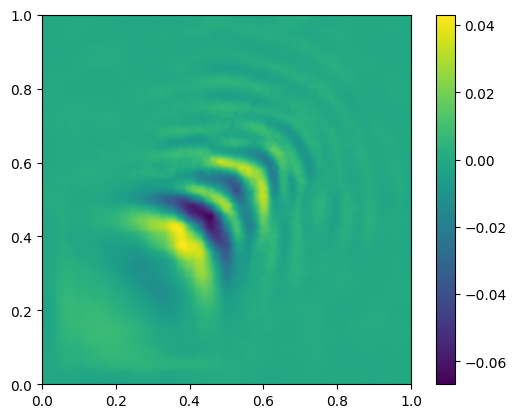

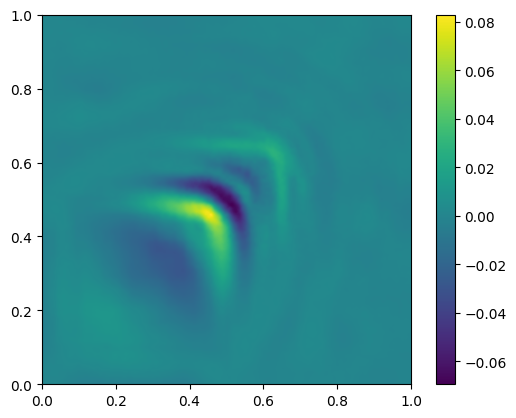

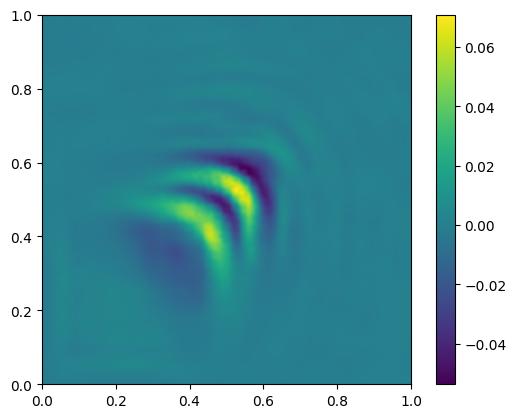

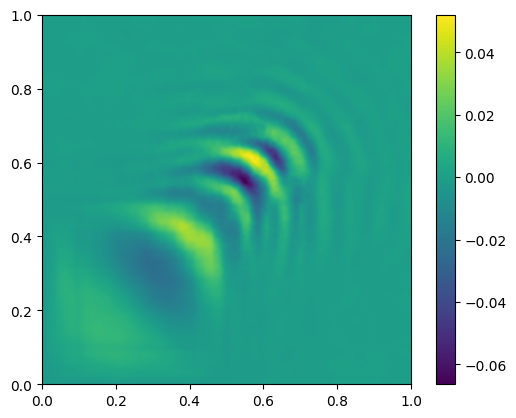

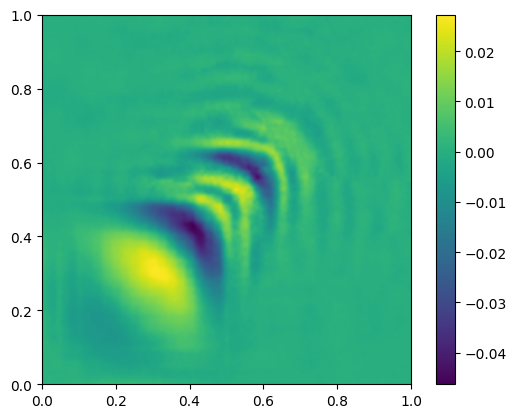

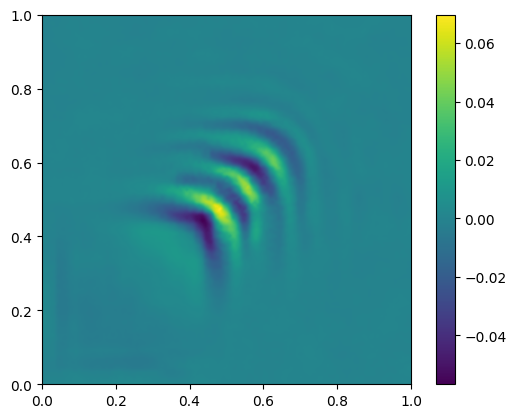

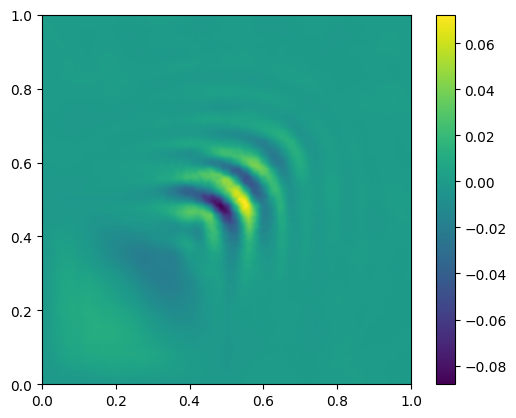

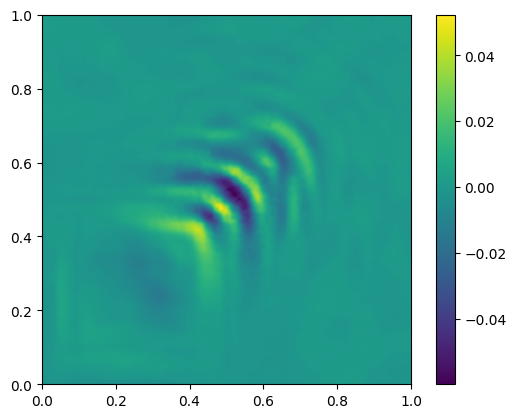

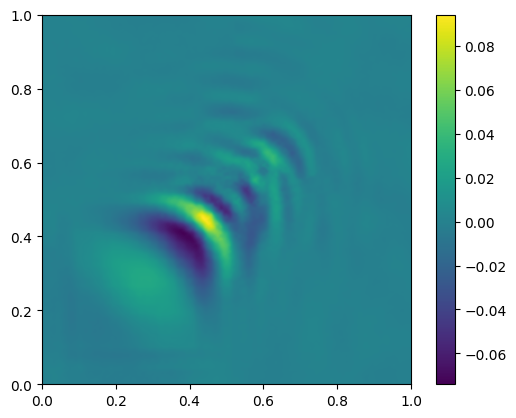

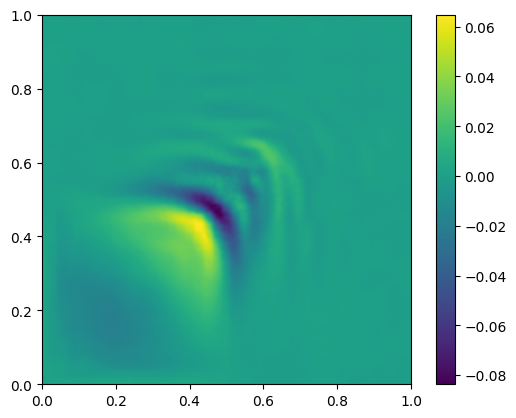

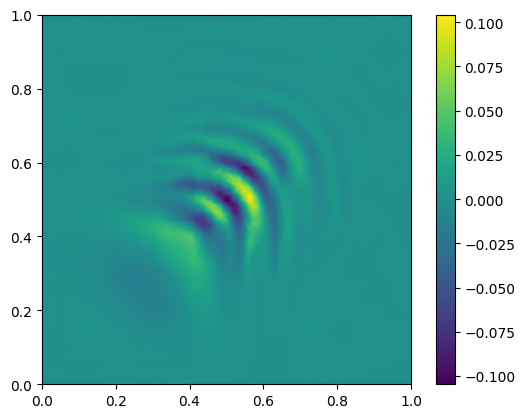

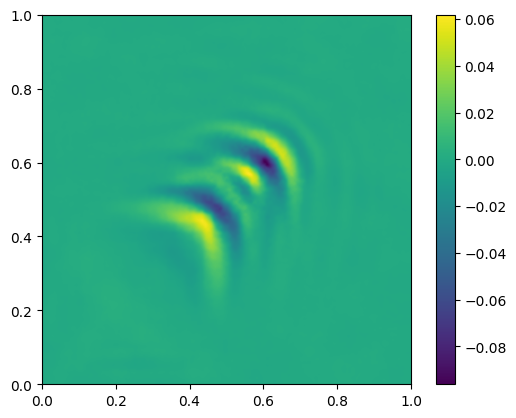

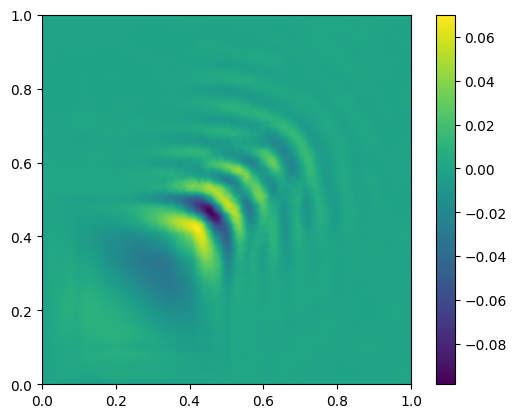

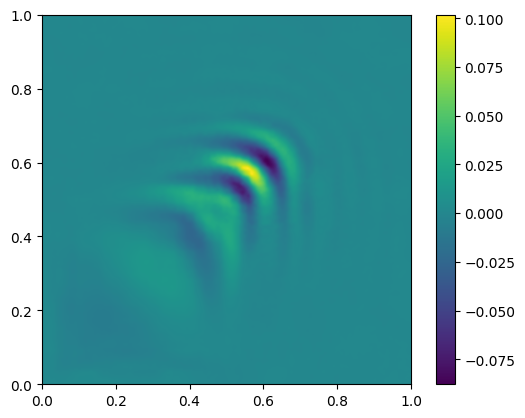

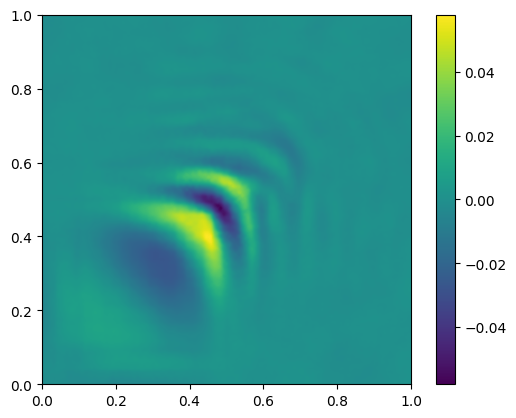

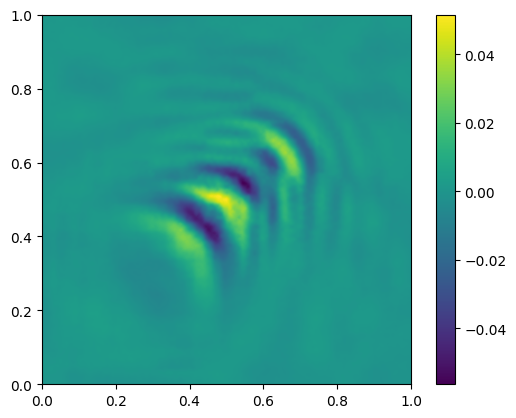

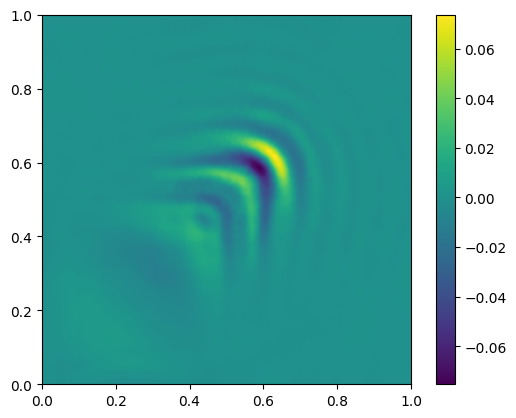

In [45]:
for basis_id in range(n):
    z = convolved_bases[basis_id].tolist()

    # target grid to interpolate to
    xi = yi = np.linspace(0,1.0,1200)
    xi,yi = np.meshgrid(xi,yi)

    # set mask
    # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='cubic')

    plt.imshow(zi,origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    plt.show()

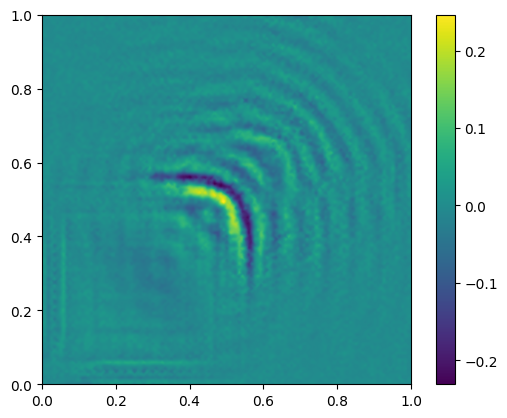

In [46]:
z = ed.nrbs.decoder.weight[0].tolist()

vmin = min(z)
vmax = max(z)

 # target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()


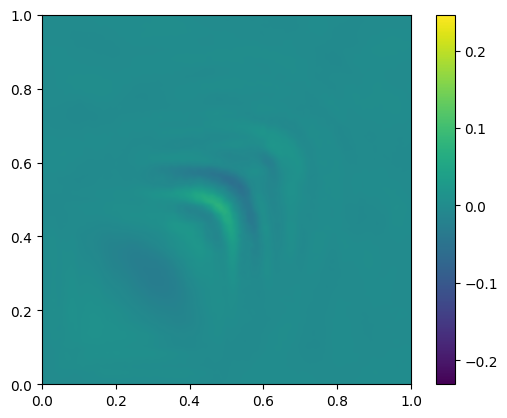

In [47]:
z = convolved_bases[0].tolist()
# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()